Average Total Infected: 850.48

=== Statistical Results ===
One-Sample t-Test: t = 1039.9165, p = 0.0000
Chi-Square Test: χ² = 375.2800, p = 0.0000


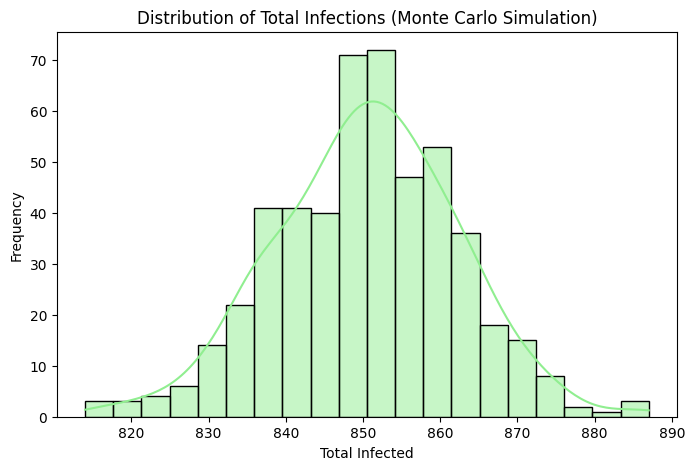

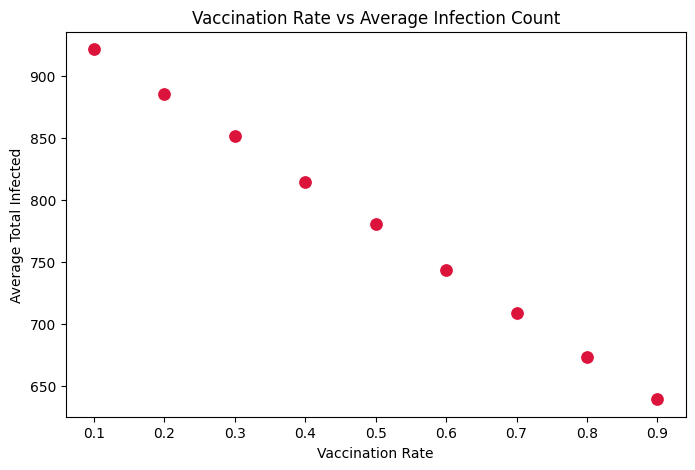

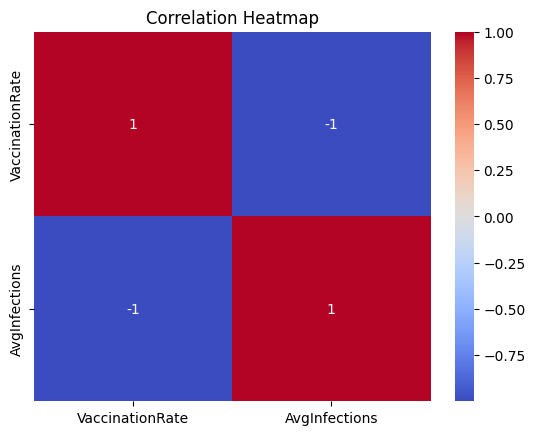

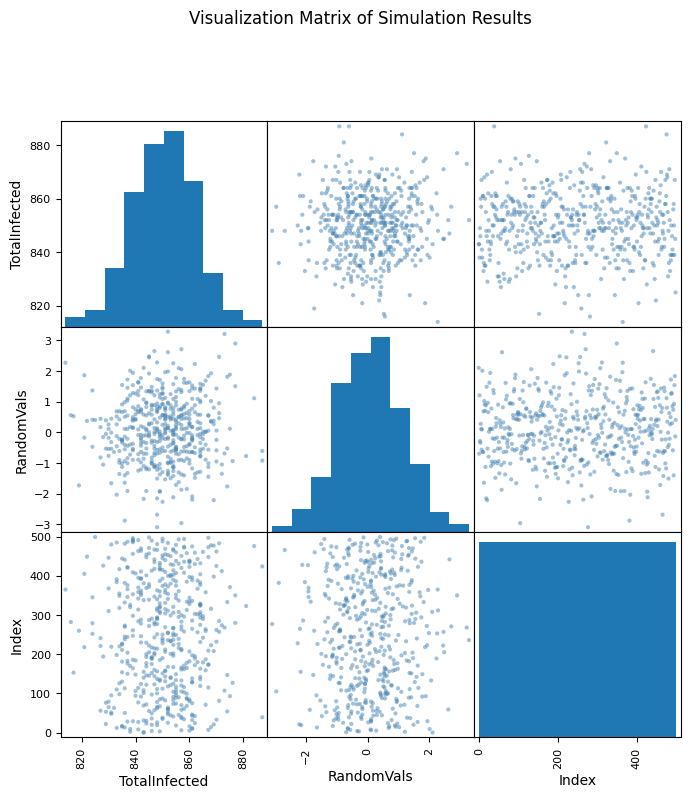


=== Summary ===
Mean Infected = 850.48
Std. Dev = 11.82
t-test p-value = 0.0000
chi-square p-value = 0.0000
Infection rate significantly differs from expected (p < 0.05)


In [1]:
# =============================
# Epidemic Spread Simulation and Statistical Analysis of Vaccination Effectiveness
# =============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

np.random.seed(2025)

# -----------------------------
# Parameters
# -----------------------------
population = 1000
days = 30
p_infect = 0.1
p_recover = 0.05
p_vaccine = 0.3
runs = 500   # reduced to 500 for speed; can increase to 1000 later

# -----------------------------
# Optimized Simulation Function
# -----------------------------
def simulate_once_fast(p_infect, p_recover, p_vaccine, population=1000, days=30):
    vaccinated = np.random.choice([0,1], size=population, p=[1-p_vaccine, p_vaccine])
    infected = np.zeros(population)
    recovered = np.zeros(population)
    infected[np.random.choice(population, 5)] = 1

    for _ in range(days):
        if np.sum(infected) == 0:  # stop early if no infections
            break

        # recovery
        recover_mask = (infected == 1) & (np.random.rand(population) < p_recover)
        infected[recover_mask] = 0
        recovered[recover_mask] = 1

        # infection spread (vectorized)
        contact_indices = np.random.randint(0, population, size=population)
        susceptible = (infected == 0) & (recovered == 0)
        infect_chance = p_infect * np.where(vaccinated == 1, 0.3, 1.0)
        new_infections = (np.random.rand(population) < infect_chance) & susceptible
        infected[new_infections] = 1

    total_infected = np.sum(recovered) + np.sum(infected)
    return total_infected

# -----------------------------
# Monte Carlo Simulation
# -----------------------------
results = np.array([simulate_once_fast(p_infect, p_recover, p_vaccine) for _ in range(runs)])
print("Average Total Infected:", np.mean(results))

# -----------------------------
# Statistical Analysis
# -----------------------------
t_stat, p_val_t = stats.ttest_1samp(results, popmean=300)
hist, _ = np.histogram(results, bins=10)
chi_stat, p_val_chi = stats.chisquare(hist)

print("\n=== Statistical Results ===")
print(f"One-Sample t-Test: t = {t_stat:.4f}, p = {p_val_t:.4f}")
print(f"Chi-Square Test: χ² = {chi_stat:.4f}, p = {p_val_chi:.4f}")

# -----------------------------
# Visualizations
# -----------------------------
plt.figure(figsize=(8,5))
sns.histplot(results, kde=True, bins=20, color='lightgreen')
plt.title("Distribution of Total Infections (Monte Carlo Simulation)")
plt.xlabel("Total Infected")
plt.ylabel("Frequency")
plt.show()

# Scatter: Vaccination rate vs infection
vacc_rates = np.linspace(0.1, 0.9, 9)
avg_infections = [np.mean([simulate_once_fast(p_infect, p_recover, v) for _ in range(50)]) for v in vacc_rates]

plt.figure(figsize=(8,5))
sns.scatterplot(x=vacc_rates, y=avg_infections, s=100, marker='o', color='crimson')
plt.title("Vaccination Rate vs Average Infection Count")
plt.xlabel("Vaccination Rate")
plt.ylabel("Average Total Infected")
plt.show()

# Heatmap
df_corr = pd.DataFrame({"VaccinationRate": vacc_rates, "AvgInfections": avg_infections})
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter Matrix
df_plot = pd.DataFrame({
    "TotalInfected": results,
    "RandomVals": np.random.normal(size=runs),
    "Index": np.arange(runs)
})
pd.plotting.scatter_matrix(df_plot, figsize=(8,8), diagonal='hist', color='steelblue')
plt.suptitle("Visualization Matrix of Simulation Results", y=1.02)
plt.show()

# -----------------------------
# Summary
# -----------------------------
print("\n=== Summary ===")
print(f"Mean Infected = {np.mean(results):.2f}")
print(f"Std. Dev = {np.std(results):.2f}")
print(f"t-test p-value = {p_val_t:.4f}")
print(f"chi-square p-value = {p_val_chi:.4f}")

if p_val_t < 0.05:
    print("Infection rate significantly differs from expected (p < 0.05)")
else:
    print("No significant difference in infection rate (p >= 0.05)")
